In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB1
from matplotlib import pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
# Define Input Parameters
dim = (150, 150)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

#Epoch
epoch = 2

In [3]:
#Preproses
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [4]:
train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/test/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 901 images belonging to 3 classes.
Found 178 images belonging to 3 classes.
Found 178 images belonging to 3 classes.


In [5]:
print(labels)

dict_keys(['busuk', 'matang', 'mentah'])


In [6]:
def tf_data_generator(generator, input_shape):

    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [15]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)
#sampai sini selesai preproses

In [16]:
model = Sequential() #mulai membuat object sequential sebagai inisiasi awal pembuatan model

model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape)) #paramater pertama(128) adalah nilai filter nya. parameter kedua adalah dimensi filter nya (3x3), parameter ketiga padding dengan menggunakan padding, kita dapat menjaga dimensi output agar tetap sama seperti deimensi input awal, parameter keempat cukup self explained disini yakni bentuk inputnya dan tipe nya RGB. (hasilnya mengikuti definisi parameter di awal praproses)
model.add(Activation('relu')) # parameter ini menggunakan aktivasi relu, relu di pilih karena berfungi lebih baik. relu adalah nilai output dari neuron bisa di nyatakan sebagai 0 apabila inputnya adalah negatif. jika inputnya positif maka output dari neuron adalah nilai input aktivasi itu sendiri
model.add(Conv2D(32, (3, 3))) # sama pada code line kedua bedanya nilai parameter nya
model.add(Activation('relu')) # sama pada code  line ke tiga
model.add(MaxPooling2D(pool_size=(2, 2))) # pooling bertujuan untuk mereduksi ukuran gambar sebanyak mungkin, supaya mempercepat komputasi karena parameter yang hars di update semakin sedikit dan mengatasi overfitting. disini juga mencoba mereduksi jumlah total node pada layer selanjutnya. pooling dakam bentuk matrik 2x2 sebagai pixel loss minimum dan precise region dimana feature dialokasikan.
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same')) # sama code line 2
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # dropout merupakan proses pencegahan overfitting pada setiap layer dan juga mempercepat proses learning.

model.add(Flatten()) # data pooling yang dimiliki berupa array 2 dimensi kemudian di konversi menjadi data satu dimensi single vektor
model.add(Dense(512)) # sebagai fully connected
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam', # metode optimasi yang digunakan
              loss='categorical_crossentropy', #kerena datanya kategorical menggunakan metode categorical_croosentropy untuk analisis loss nya
              metrics=['accuracy']) #nilai metrik yang di ukur menggunakan nilai akurasi sebagai nilai pengukurannya

Compiling Model.......


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 128)     3584      
_________________________________________________________________
activation_6 (Activation)    (None, 150, 150, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 148, 148, 32)      36896     
_________________________________________________________________
activation_7 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 74, 74, 64)       

In [18]:
# get base models
base_model = EfficientNetB1(
    input_shape=input_shape, #merupakan dimensi dari gambar yang akan kita gunakan/ input dari citra
    include_top=False, #adalah perintah untuk menyertakan apakah model yang digunakan akan disertakan dengan top layer dari arsitektur network tersebut atau misalkan top network tersebut memiliki 3 node yaitu : flatten layer, layer dengan 1024 node dan fungsi aktivasinya, lalu prediction node dimana jumlah node sesuai dengan banyaknya jumlah kelas. Dikarenakan jumlah kelas pada imagenet adalah 1000 maka ini tidak cocok dengan jumlah kelas yang kita miliki yaitu hanya 5. sehingga include top di sini adalah false.
    weights='noisy-student',#adalah bobot dari masing-masing layer yang sudah di training berdasarkan bobot imagenet. Kita juga bisa meniadakan ini dengan menggunakan None Namun ketika tidak menggunakan pre-trained weight proses training kita akan lebih lama karena initial value dari weight nya random sehingga perlu banyak penyesuaian terhadap data yang akan kita gunakan.
    classes=num_class, #jumlah class yang dimiliki
)

In [19]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [21]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [22]:
EPOCH = 10

In [23]:
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator),
        shuffle=True,
        verbose = 1)

Epoch 1/10
57/57 [==============================] - 911s 15s/step - loss: 0.3771 - accuracy: 0.8624 - val_loss: 0.3148 - val_accuracy: 0.8989
Epoch 2/10
57/57 [==============================] - 675s 12s/step - loss: 0.1018 - accuracy: 0.9678 - val_loss: 0.2247 - val_accuracy: 0.9213
Epoch 3/10
57/57 [==============================] - 715s 13s/step - loss: 0.0776 - accuracy: 0.9822 - val_loss: 0.1431 - val_accuracy: 0.9775
Epoch 4/10
57/57 [==============================] - 466s 8s/step - loss: 0.0738 - accuracy: 0.9711 - val_loss: 0.0761 - val_accuracy: 0.9831
Epoch 5/10
57/57 [==============================] - 464s 8s/step - loss: 0.0571 - accuracy: 0.9778 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 6/10
57/57 [==============================] - 467s 8s/step - loss: 0.0490 - accuracy: 0.9856 - val_loss: 0.0308 - val_accuracy: 0.9888
Epoch 7/10
57/57 [==============================] - 479s 8s/step - loss: 0.0644 - accuracy: 0.9800 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 8/10

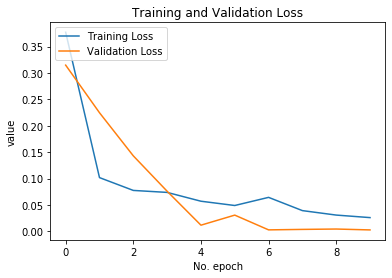

In [24]:
from matplotlib import pyplot as plt

# Plot history: MAE loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

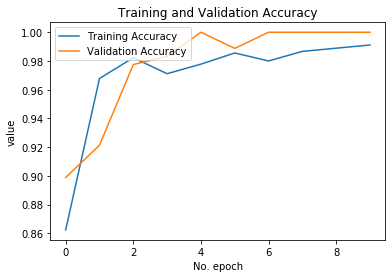

In [25]:
# Plot history: MSE acc
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [27]:
import os

MODEL_BASE_PATH = "model"
PROJECT_NAME = "pak dedy"
SAVE_MODEL_NAME = "model.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
    
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

Saving Model At model\pak dedy\model.h5...


In [28]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 1.0000 
Loss on training data: 0.0041 



In [29]:
#cetak akurasi model
scores = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 100.00%


# Optimasi model

In [33]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os

In [34]:
def image_gen_w_aug(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range = 30,  
                                      zoom_range = 0.2, 
                                      width_shift_range=0.1,  
                                      height_shift_range=0.1,
                                      validation_split = 0.15)
    
  
    
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator =          train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 214,
                                  class_mode = 'categorical',
                                  subset='training')
    
    val_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 37,
                                  class_mode = 'categorical',
                                  subset = 'validation')
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(75,75),
                                 batch_size = 37,
                                 class_mode = 'categorical')
    return train_generator, val_generator, test_generator

In [35]:
def model_output_for_TL (pre_trained_model, last_output):    
    x = Flatten()(last_output)
    
    # Dense hidden layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output neuron. 
    x = Dense(3, activation='softmax')(x)
    
    model = Model(pre_trained_model.input, x)
    
    return model

In [36]:
train_dir = os.path.join(r'C:\Users\Muksin Alfalah\dataset\Train')
test_dir = os.path.join(r'C:\Users\Muksin Alfalah\dataset\Test')

In [37]:
train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, test_dir)

Found 766 images belonging to 3 classes.
Found 135 images belonging to 3 classes.
Found 178 images belonging to 3 classes.


In [38]:
pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed3')
last_output = last_layer.output

model_TL = model_output_for_TL(pre_trained_model, last_output)
model_TL.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
history = model_TL.fit(
      train_generator,
      steps_per_epoch=len(train_generator),  
      epochs=10,
      verbose=1,
      validation_data = validation_generator)

tf.keras.models.save_model(model_TL,'my_model.hdf5')

Epoch 1/10
4/4 [==============================] - 247s 62s/step - loss: 15.4140 - accuracy: 0.3460 - val_loss: 6.4082 - val_accuracy: 0.4074
Epoch 2/10
4/4 [==============================] - 232s 59s/step - loss: 6.0813 - accuracy: 0.3838 - val_loss: 4.7060 - val_accuracy: 0.2963
Epoch 3/10
4/4 [==============================] - 231s 60s/step - loss: 2.5741 - accuracy: 0.4778 - val_loss: 3.2486 - val_accuracy: 0.4667
Epoch 4/10
4/4 [==============================] - 232s 59s/step - loss: 2.7562 - accuracy: 0.5914 - val_loss: 2.0206 - val_accuracy: 0.4889
Epoch 5/10
4/4 [==============================] - 234s 59s/step - loss: 1.0856 - accuracy: 0.6867 - val_loss: 1.5631 - val_accuracy: 0.4074
Epoch 6/10
4/4 [==============================] - 232s 60s/step - loss: 1.0106 - accuracy: 0.5979 - val_loss: 0.6183 - val_accuracy: 0.7407
Epoch 7/10
4/4 [==============================] - 238s 59s/step - loss: 0.5832 - accuracy: 0.7663 - val_loss: 1.6531 - val_accuracy: 0.4741
Epoch 8/10
4/4 [===